In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ejercicio 1

In [56]:
def image_to_array(image: str) -> np.ndarray:
    image = cv2.imread(f'images/{image}', cv2.IMREAD_GRAYSCALE)
    
    return np.asarray(image, dtype=np.float32) / 255.0
    
def pairs_array(array: np.ndarray) -> np.ndarray:
    x1 = array[:-1, :].ravel()
    x2 = array[1:, :].ravel()
    
    return np.stack((x1, x2), 1)

### a)

In [57]:
def show_image(axis: plt.Axes, image: str, title: str = 'Imagen Original') -> None:
    image = cv2.imread(f'images/{image}', cv2.IMREAD_GRAYSCALE)
    
    axis.imshow(image, cmap="gray")
    
    axis.set_title(title)
    axis.axis("off")
    
def show_dispersion(axis: plt.Axes, x1: np.ndarray, x2: np.ndarray, _s: int = 4, _alpha: float = 0.6, title: str = 'Dispersión de pares verticales') -> None:
    axis.scatter(x1, x2, s=_s, alpha=_alpha)
    
    axis.set_title(title)
    axis.set_xlabel("X₁")
    axis.set_ylabel("X₂")
    
def show_image_and_dispersion(image: str, s: float = 4, alpha: float = 0.6, _figsize: tuple[float, float] = (14, 7)) -> None:
    array = image_to_array(image)
    
    X = pairs_array(array)

    x1 = X[:, 0]
    x2 = X[:, 1]

    axes = plt.subplots(1, 2, figsize=_figsize)[1]

    show_image(axes[0], image)
    show_dispersion(axes[1], x1, x2, s, alpha)

    plt.tight_layout()
    plt.show()

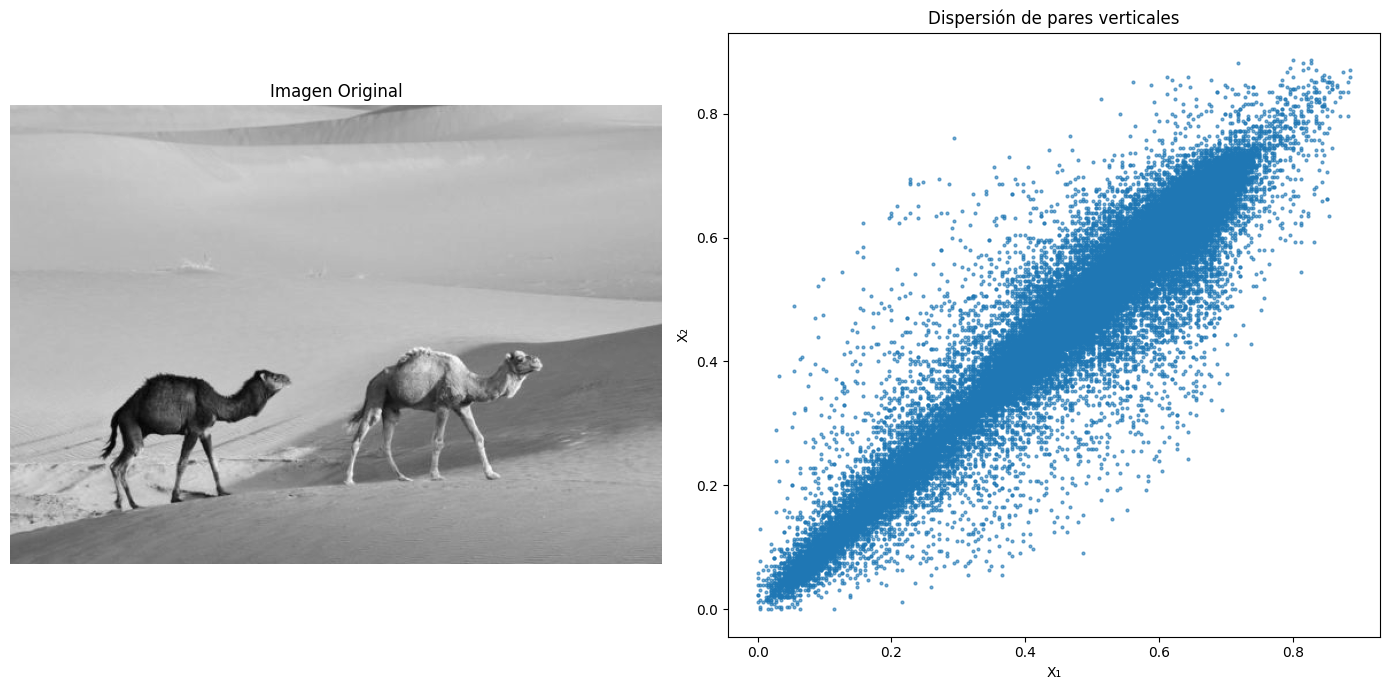

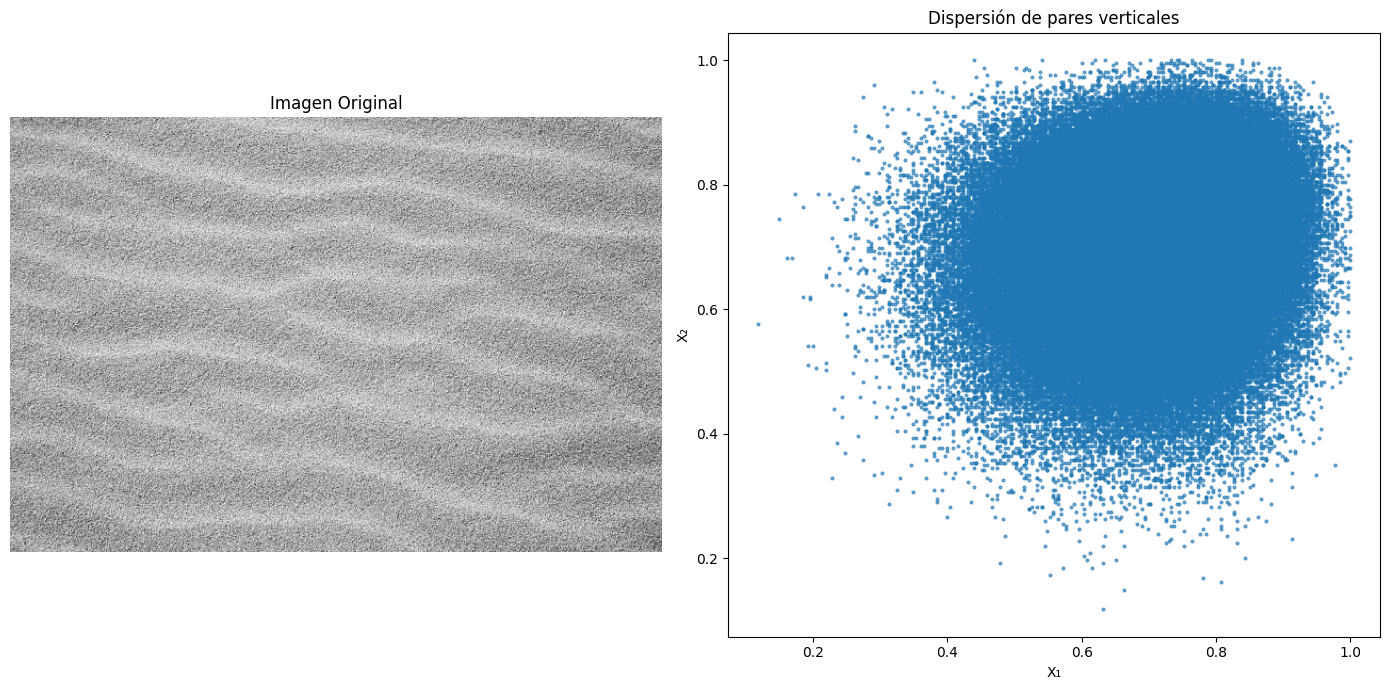

In [58]:
show_image_and_dispersion('img_01.jpg')
show_image_and_dispersion('img_02.jpg')

### b)

In [59]:
def decorrelation(x: np.ndarray):
    mean = np.mean(x, axis=0)
    x_centered = x - mean
    
    cov_matrix = np.cov(x_centered, rowvar=False)
    
    avals, avecs = np.linalg.eigh(cov_matrix)
    
    sorted_avals = np.argsort(avals)[::-1]
    sorted_avecs = avecs[:,sorted_avals]
    
    return x_centered @ sorted_avecs

**¿Está bien esto?**

In [60]:
array1 = image_to_array('img_01.jpg')
x1 = pairs_array(array1)
decorrelation1 = decorrelation(x1)

print(f'Coeficiente de correlación de X₁ estimado:\n\n{decorrelation1}')

array2 = image_to_array('img_02.jpg')
x2 = pairs_array(array2)
decorrelation2 = decorrelation(x2)

print(f'\nCoeficiente de correlación de X₂ estimado:\n\n{decorrelation2}')

Coeficiente de correlación de X₁ estimado:

[[ 0.17650937 -0.02469638]
 [ 0.17650937 -0.02469638]
 [ 0.17650937 -0.02469638]
 ...
 [-0.14238644 -0.03845682]
 [-0.15070626 -0.04122707]
 [-0.15625221 -0.04122523]]

Coeficiente de correlación de X₂ estimado:

[[-0.15400189 -0.03871907]
 [-0.11518867 -0.05537629]
 [-0.15399356 -0.02208126]
 ...
 [-0.19551458  0.12490683]
 [-0.17893779  0.00288793]
 [-0.10960667  0.01671809]]


### c)

In [61]:
def graficar_vector(vect, labels, _s: float = 4, _alpha: float = 0.6, title: str = 'Dispersión', _figsize: tuple[float, float] = (7, 7)):
    plt.figure(figsize=_figsize)
    plt.scatter(vect[:, 0], vect[:, 1], s=_s, alpha=_alpha)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

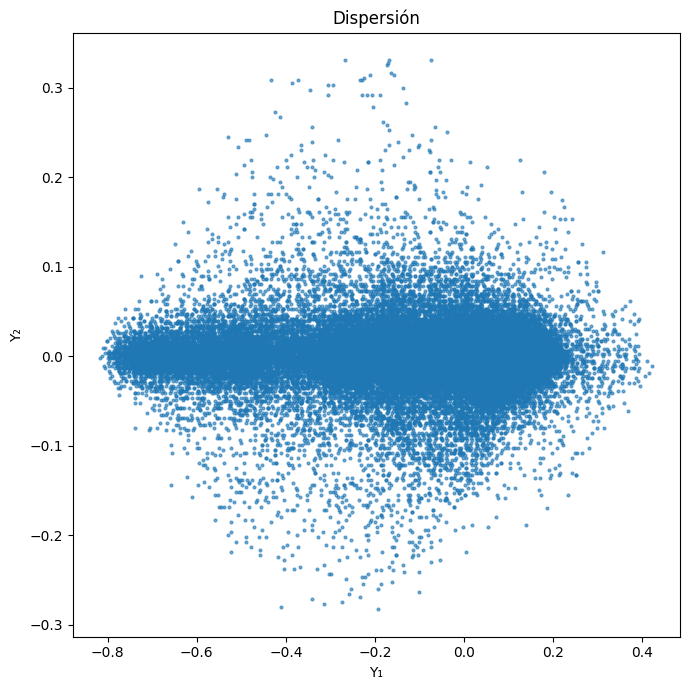

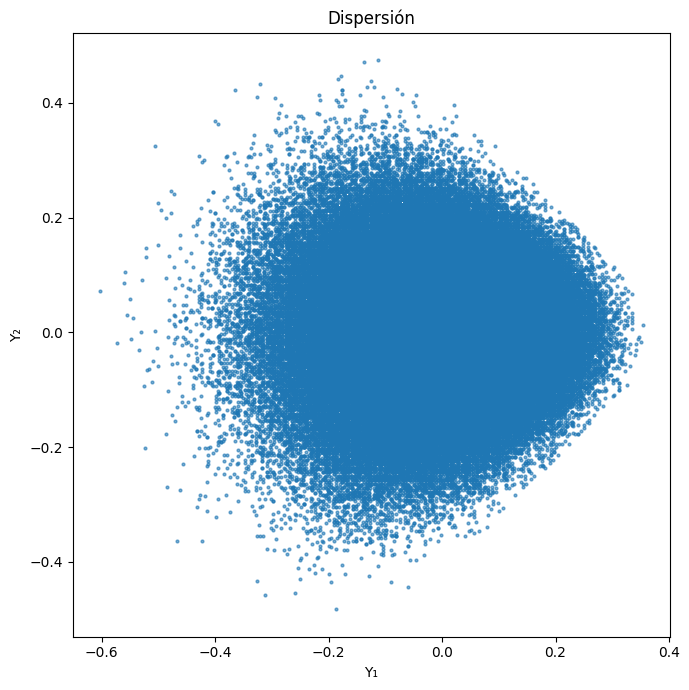

In [73]:
array1 = image_to_array('img_01.jpg')
x1 = pairs_array(array1)
decorrelation1 = decorrelation(x1)

graficar_vector(decorrelation1, ['Y₁', 'Y₂'])

array2 = image_to_array('img_02.jpg')
x2 = pairs_array(array2)
decorrelation2 = decorrelation(x2)

graficar_vector(decorrelation2, ['Y₁', 'Y₂'])

# Ejercicio 2

### a)

In [74]:
def image_to_blocks(image: str, block_size: int = 8) -> tuple[np.ndarray, list[tuple[int, int]], tuple[int, int], tuple[int, int]]:
    img = cv2.imread(f'images/{image}', cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0 #normalizo

    # dimensiones originales
    height, width = img.shape

    # padding (lleno con pixeles extra los bordes para que me queden bloques no solapados)
    pad_height = (block_size - (height % block_size)) % block_size
    pad_width = (block_size - (width % block_size)) % block_size
    
    pad_img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='reflect') # rellenamos con valores reflejados
    
    new_height, new_width = pad_img.shape

    # nos guardamos cada bloque y su posición
    blocks = []
    pos = []

    for i in range(0, new_height, block_size):
        for j in range(0, new_width, block_size):
            b = pad_img[i:i + block_size, j:j + block_size].ravel()
            blocks.append(b)
            pos.append((i, j))
    
    X = np.array(blocks, dtype=np.float32).T
    
    return X, pos, (new_height, new_width), (height, width)

def pca_fit_cov_eigh(X: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    width = X.shape[1]
    
    mu = X.mean(axis=1, keepdims=True)
    Xc = X - mu # Centrar

    C = (Xc @ Xc.T) / width # Matriz de covarianza

    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    
    # Ordenar descendentemente
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    return mu, evecs, evals

def space_saving(m: int, S: float = 0.8) -> int:
    return int(np.ceil((1 - S) * m))

def pca_project(evecs: np.ndarray, mu: np.ndarray, X: np.ndarray, S: float = 0.8) -> tuple[np.ndarray, int]:
    m = evecs.shape[1] # Cantidad total de autovectores
    
    k = space_saving(m, S) # k usado para obtener S deseado
    
    Xc = X - mu # Centrar
    Uk = evecs[:, :k] # k autovectores más importantes
    Y = Uk.T @ Xc
    
    return Y, k

def pca_transform(image: str, block_size: int = 8, S: float = 0.8) -> tuple[np.ndarray, np.ndarray, np.ndarray, int, np.ndarray, list[tuple[int, int]], tuple[int, int], tuple[int, int]]:
    X, pos, new_shape, original_shape = image_to_blocks(image, block_size)
    mu, evecs, evals = pca_fit_cov_eigh(X)
    
    Y, k = pca_project(evecs, mu, X, S)
    
    return Y, evecs, evals, k, mu, pos, new_shape, original_shape

### b)

In [ ]:
def evals_graph(evals: np.ndarray, k: int) -> None:
    length = len(evals)
    x = np.arange(1, length + 1)

    # Separamos autovalores entre conservados vs descartados
    evals_keep = np.zeros_like(evals)
    evals_keep[:k] = evals[:k]
    
    evals_disc = np.zeros_like(evals)
    evals_disc[k:] = evals[k:]

    ax1: plt.Axes = plt.subplots(figsize=(8, 4))[1]

    # Normalización global con suavizado y piso mínimo de intensidad
    alpha = 0.5
    vals_all = evals.astype(float)
    vals_all = np.maximum(vals_all, 0.0)
    norm_all = (vals_all - vals_all.min())**alpha
    norm_all = norm_all / (norm_all.max() + 1e-8)
    norm_all = 0.2 + 0.8 * norm_all   # piso 0.2 para que nada quede demasiado claro
    colors_all = plt.cm.Blues(norm_all)

    ax1.bar(x[:k], evals_keep[:k], label="Conservados", color=colors_all[:k], zorder=3)
    ax1.bar(x[k:], evals_disc[k:], label="Descartados", color="#bdbdbd", zorder=3)

    ax1.set_xlabel("Índice de componente")
    ax1.set_ylabel("Autovalor (varianza)")
    ax1.set_title("Autovalores de $C_X$")

    # Línea vertical para k
    ax1.axvline(x=k, color='#2b8cbe', linestyle='--', linewidth=1, label=f"k = {k}", zorder=4)

    # Grid y límites
    ax1.grid(True, alpha=0.25, zorder=0)
    ax1.set_xlim(0, length + 1.5)

    ax1.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

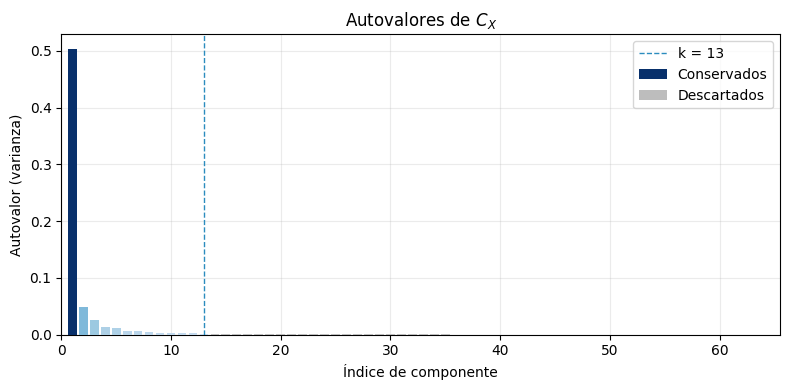

In [92]:
block_size = 8
S = 0.8

Y, evecs, evals, k, mu, pos, new_shape, original_shape = pca_transform('img_03.jpg', block_size, S)

evals_graph(evals, k)

# Ejercicio 3

### a)

In [93]:
def pca_reconstruct(evecs: np.ndarray, mu: np.ndarray, Y: np.ndarray) -> np.ndarray:
    k = Y.shape[0]
    Uk = evecs[:, :k]
    X_compressed = Uk @ Y + mu
    
    return X_compressed

def blocks_to_image(X_compressed: np.ndarray, pos: list[tuple[int,int]], new_shape: tuple[int,int], original_shape: tuple[int,int], block_size: int = 8) -> np.ndarray:
    new_h, new_w = new_shape
    H, W = original_shape

    canvas = np.zeros((new_h, new_w), dtype=np.float32)
    
    for idx, (i, j) in enumerate(pos):
        patch = X_compressed[:, idx].reshape(block_size, block_size)
        canvas[i:i+block_size, j:j+block_size] = patch

    return np.clip(canvas[:H, :W], 0.0, 1.0)

def pca_inverse_transform(Y: np.ndarray, mu: np.ndarray, evecs: np.ndarray, pos: list[tuple[int,int]], new_shape: tuple[int,int], original_shape: tuple[int,int], block_size: int = 8) -> np.ndarray:
    Xrec = pca_reconstruct(evecs, mu, Y)
    img_rec = blocks_to_image(Xrec, pos, new_shape, original_shape, block_size)
    
    return img_rec

### b)

In [94]:
def show_image_from_array(axis: plt.Axes, array: np.ndarray, title: str = 'Imagen Reconstruida') -> None:
    array = np.asarray(array)

    axis.imshow(array, cmap='gray')
    
    axis.set_title(title)
    axis.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def show_images_comparison(image: str, arrays_list: list[np.ndarray] | np.ndarray, _figsize: tuple[float, float] = (14, 7)) -> None:
    if type(arrays_list) == list:
        rows = len(arrays_list)
        
        _figsize = _figsize[0], rows * _figsize[1]
        axes = plt.subplots(rows, 2, figsize=_figsize)[1]
        
        if rows > 1:
            for i, array in enumerate(arrays_list):
                show_image(axes[i][0], image)
                show_image_from_array(axes[i][1], array)
        else:
            show_image(axes[0], image)
            show_image_from_array(axes[1], array)
    else:
        axes = plt.subplots(1, 2, figsize=_figsize)[1]

        show_image(axes[0], image)
        show_image_from_array(axes[1], arrays_list)

    plt.tight_layout()
    plt.show()

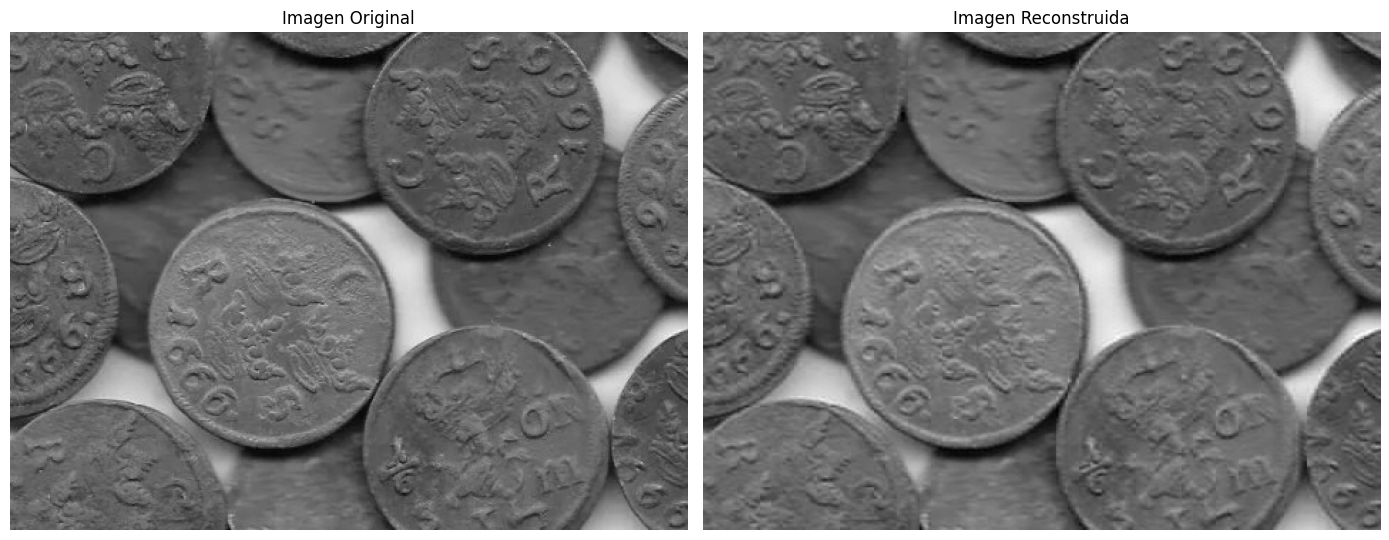

<Figure size 640x480 with 0 Axes>

In [100]:
image = 'img_03.jpg'
block_size = 8
S = 0.8

Y, evecs, evals, k, mu, pos, new_shape, original_shape = pca_transform(image, block_size, S)

array = pca_inverse_transform(Y, mu, evecs, pos, new_shape, original_shape, block_size)

show_images_comparison(image, array)

# Ejercicio 4

### a)

In [101]:
def mse(original: np.ndarray, reconstructed: np.ndarray) -> float:
    sq_error = (original - reconstructed) ** 2
    mean_sq_error = np.mean(sq_error)
    
    return mean_sq_error

def plot_mse_vs_s(S_list: list[float], mse_list: list[float], _figsize: tuple[float, float] = (7, 7)):
    plt.figure(figsize=_figsize)
    plt.plot(S_list, mse_list, marker="o", linestyle="-", color="blue")
    plt.xlabel("S (Space Saving)")
    plt.ylabel("MSE")
    plt.title("MSE vs Space Saving")
    plt.grid(True)
    plt.show()

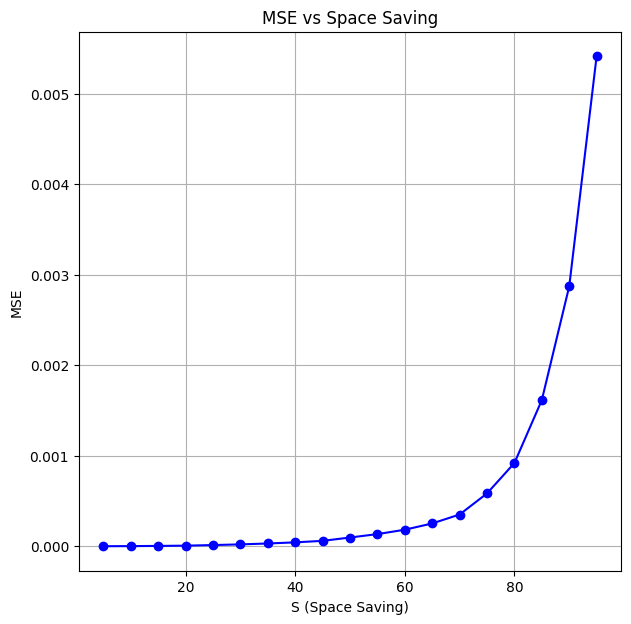

In [102]:
image = 'img_04.jpg'
block_size = 8

S_list = list(range(5, 100, 5))
mse_list = []

for s in S_list:
    s /= 100
    original_array = image_to_array(image)
    
    Y, evecs, evals, k, mu, pos, new_shape, original_shape = pca_transform(image, block_size, s)

    reconstructed_array = pca_inverse_transform(Y, mu, evecs, pos, new_shape, original_shape, block_size)
    
    mse_list.append(mse(original_array, reconstructed_array))
    
plot_mse_vs_s(S_list, mse_list)

### b)

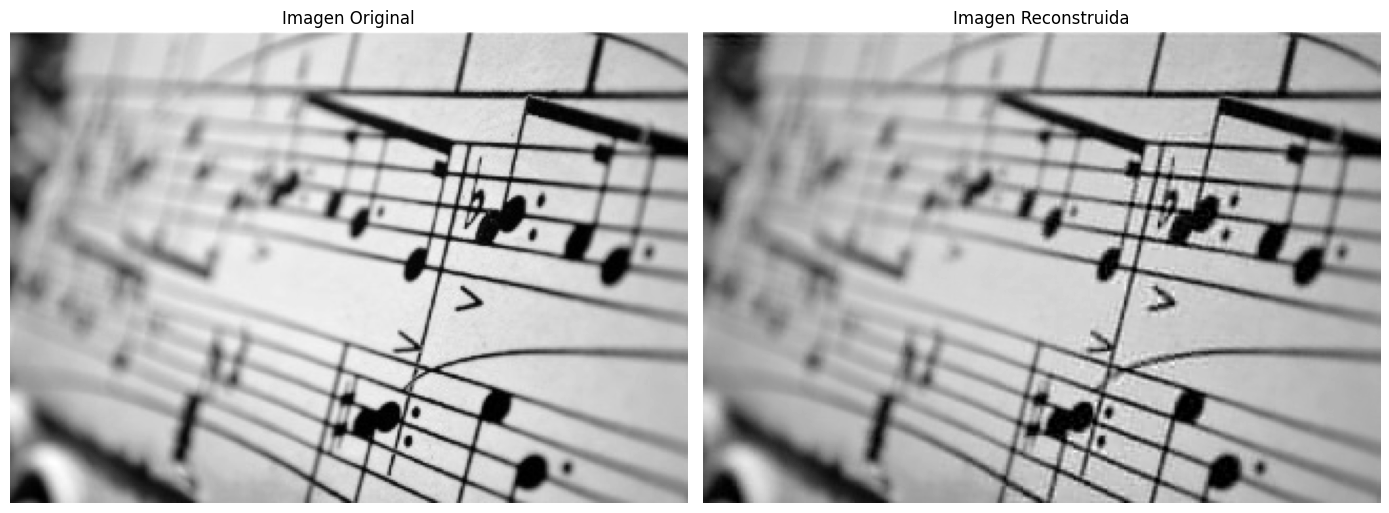

<Figure size 640x480 with 0 Axes>

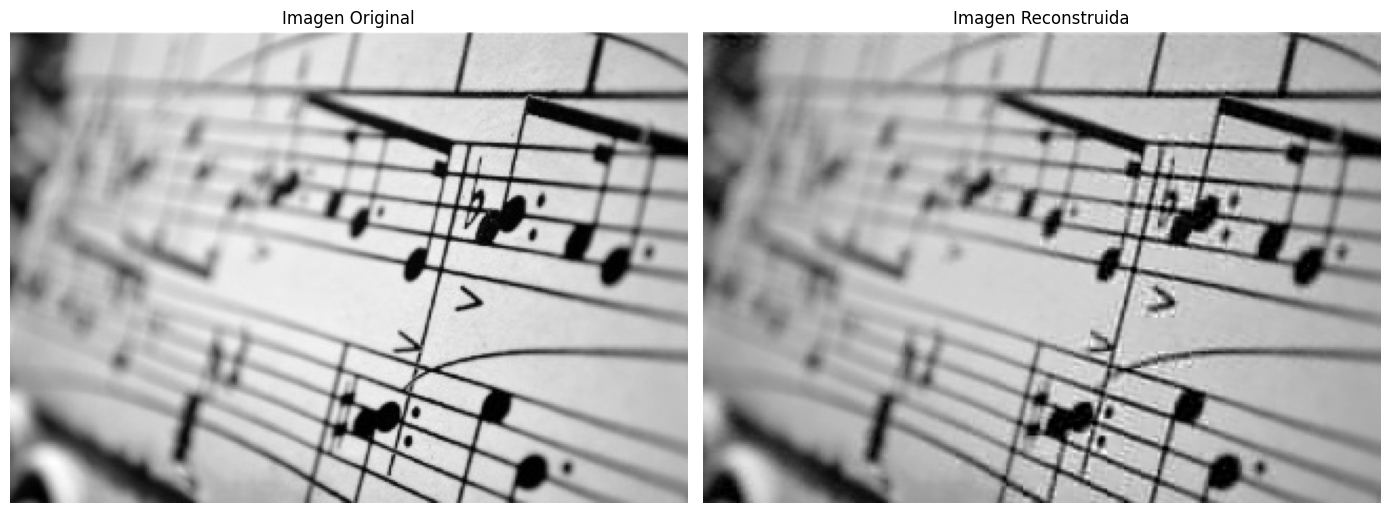

<Figure size 640x480 with 0 Axes>

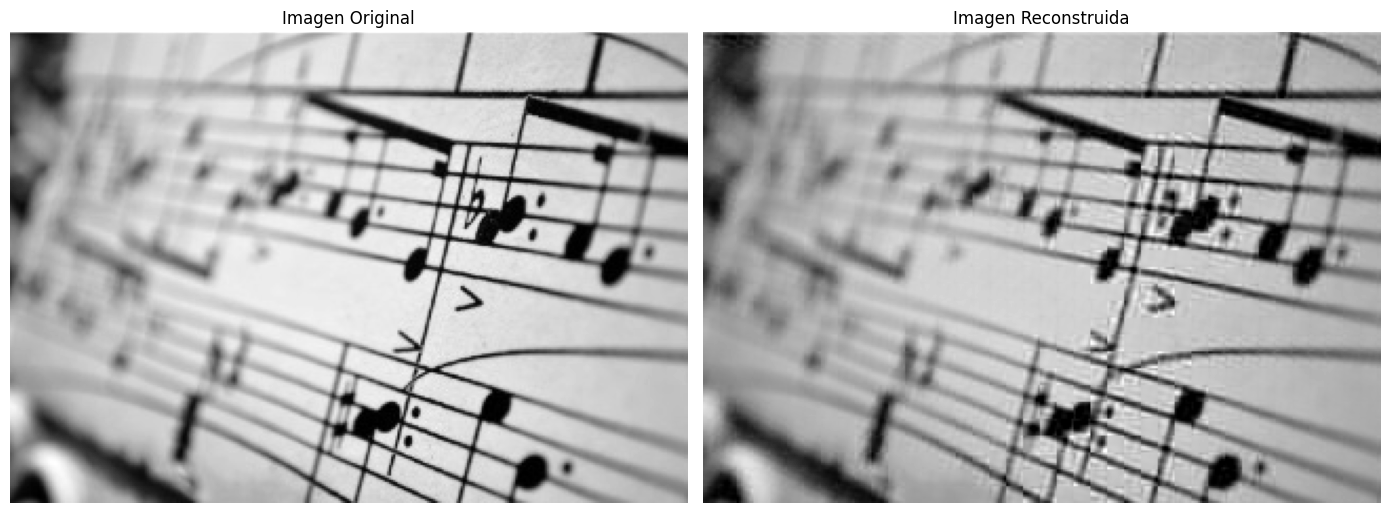

<Figure size 640x480 with 0 Axes>

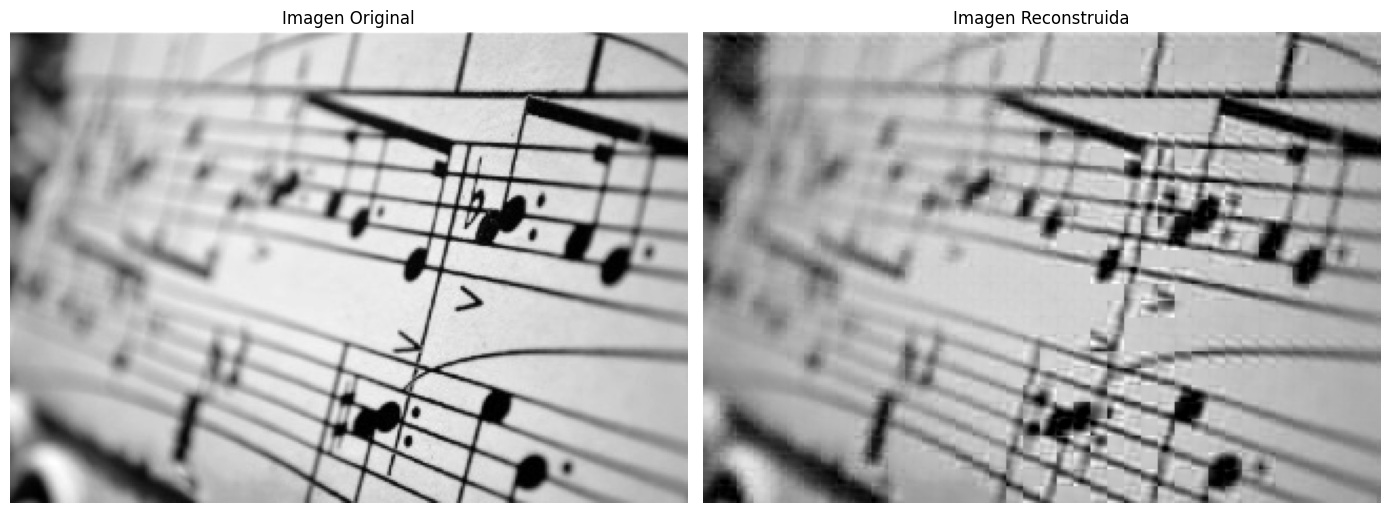

<Figure size 640x480 with 0 Axes>

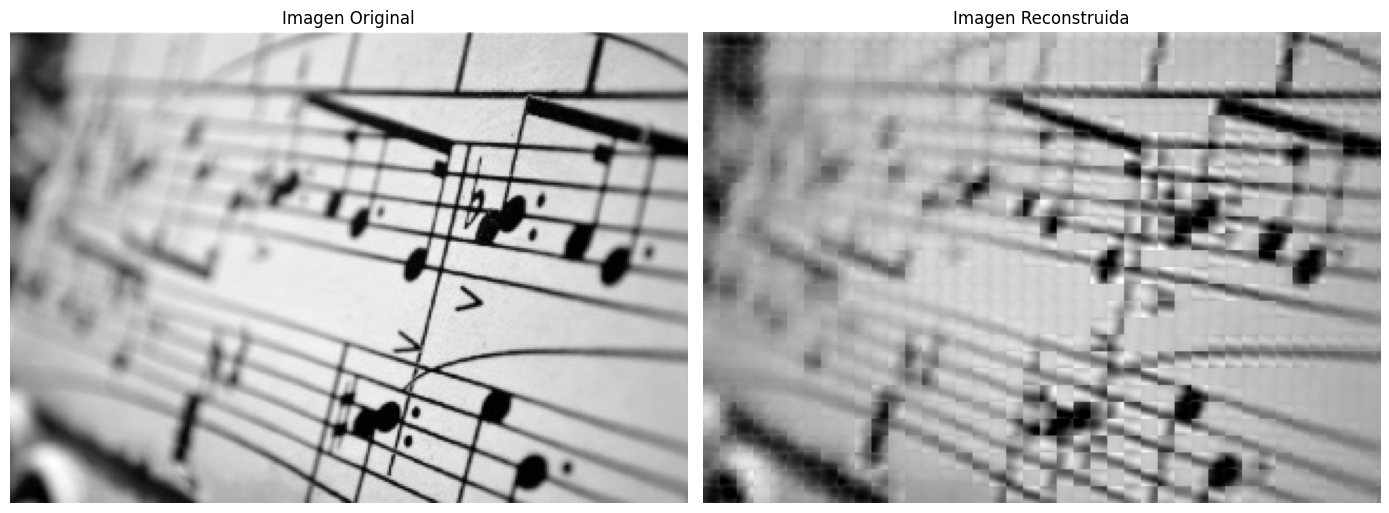

<Figure size 640x480 with 0 Axes>

In [103]:
image = 'img_04.jpg'
block_size = 8

S_list = list(range(75, 100, 5))
mse_list = []
arrays_list = []

for i, s in enumerate(S_list):
    s /= 100
    original_array = image_to_array(image)
    
    Y, evecs, evals, k, mu, pos, new_shape, original_shape = pca_transform(image, block_size, s)

    reconstructed_array = pca_inverse_transform(Y, mu, evecs, pos, new_shape, original_shape, block_size)
    
    show_images_comparison(image, reconstructed_array)